# Temporal Fusion Transformer

### Multi-horizon building energy forecasting using Temporal Fusin Transformer

## References: 

Paper: https://arxiv.org/abs/1912.09363

Pytorch Forecasting Tutorial: https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html

Dataset: https://ieee-dataport.org/open-access/8-years-hourly-heat-and-electricity-demand-residential-building

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import MultiNormalizer, TorchNormalizer, EncoderNormalizer
from pytorch_forecasting.metrics import MultiLoss, RMSE, MASE, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from sklearn.preprocessing import StandardScaler

# Data Loading & Preperation:

In [2]:
# Read Data:
current_dir = os.getcwd()
os.chdir("..")
os.chdir("..")
df = pd.read_csv(r"data/raw/data.csv")
os.chdir(current_dir)

In [3]:
# Rename Columns:
col_mapping = {"Time": "ts",
            "air_pressure[mmHg]": "air_pressure",
            "air_temperature[degree celcius]": "air_temperature",
            "relative_humidity[%]": "relative_humidity",
            "wind_speed[M/S]": "wind_speed",
            "solar_irridiation[W/m²]": "solar_irridiation",
            "total_cloud_cover[from ten]": "total_cloud_cover",
            "electricity_demand_values[kw]": "electricity_demand_values",
            "heat_demand_values[kw]": "heat_demand_values"}
df = df.rename(columns = col_mapping)

In [4]:
# Clean category names for total_cloud_cover:
# Use either 0 or 1
# This feature will not be used
cloud_mapping = {"no clouds": 0,
                 "2/10–3/10.": 1,
                 "5/10.": 1,
                 "10/10.": 1,
                 "Sky obscured by fog and/or other meteorological phenomena.": 1,
                 "7/10 – 8/10.": 1,
                 "nan": np.NaN,
                 "4/10.": 1}

df = df.replace({"total_cloud_cover": cloud_mapping})

In [5]:
# Replace NaN with means:
column_means = df.mean()
df = df.fillna(column_means)

df["ts"] = pd.to_datetime(df["ts"])
df["time_idx"] = df.index
df["month"] = df.ts.dt.month.astype(str).astype("category")
df["weekday"] = df.ts.dt.weekday.astype(str).astype("category")
df["hour"] = df.ts.dt.hour.astype(str).astype("category")
df["id"] = "0" # Required for time series dataset, for each group. This data set has only one group, as its from the same building

# Set data types:
df["air_pressure"] = df["air_pressure"].fillna(0).astype("float64")
df["air_temperature"] = df["air_temperature"].fillna(0).astype("float64")
df["wind_speed"] = df["wind_speed"].fillna(0).astype("float64")
df["relative_humidity"] = df["relative_humidity"].fillna(0).astype("float64")
df["solar_irridiation"] = df["solar_irridiation"].fillna(0).astype("float64")
df["electricity_demand_values"] = df["electricity_demand_values"].fillna(0).astype("float64")
df["heat_demand_values"] = df["heat_demand_values"].fillna(0).astype("float64")
df["total_cloud_cover"] = df["total_cloud_cover"].fillna(0).astype("float64")

<ipython-input-5-7ab6252c9357>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  column_means = df.mean()


In [6]:
# Standardize:
scaler = StandardScaler()
cols = ["air_pressure", "air_temperature", "relative_humidity", 
"wind_speed", "solar_irridiation", "total_cloud_cover",
 "electricity_demand_values", "heat_demand_values"]

df[cols] = scaler.fit_transform(df[cols])

# Create Timeseries Dataset

In [7]:
target_name_1 = "heat_demand_values"
target_name_2 = "electricity_demand_values"

In [8]:
days_test = 7
test_lengths = 24 * days_test
val_cutoff = int(df.shape[0] * 0.80)
df_test = df[-test_lengths:]
df_train = df[:val_cutoff]
df_val = df[val_cutoff:-test_lengths]

In [9]:
days_prediction = 1
max_prediction_length = 24 * days_prediction

training = TimeSeriesDataSet(
    data = df_train, # Training dataset
    time_idx = "time_idx",
    target = target_name_1, # Targets to predict
    group_ids = ["id"], # Only one group as data comes from a single building.
    max_encoder_length = test_lengths,
    min_encoder_length = 24,
    max_prediction_length = max_prediction_length,  
    min_prediction_length = 24,
    static_categoricals = [], # List of categorical variables that do not change over time
    static_reals = [], # List of continuous variables that do not change over time
    time_varying_known_categoricals = [], # List of categorical variables that change over time and are known in the future
    variable_groups = {},  # Group of categorical variables can be treated as one variable
    time_varying_known_reals = [], # List of categorical variables that change over time and are known in the future
    time_varying_unknown_categoricals = [], # List of categorical variables that change over time and are not known in the future
    time_varying_unknown_reals = [ # List of continuous variables that change over time and are known in the future
        "air_pressure",
        "air_temperature",
        "relative_humidity",
        "wind_speed",
        "solar_irridiation",
        target_name_2],
    target_normalizer = TorchNormalizer(),
    add_relative_time_idx = True,
    add_target_scales = True,
    add_encoder_length = True,
    allow_missing_timesteps = False
)

# Create validation/test dataset:
validation = TimeSeriesDataSet.from_dataset(training, df_val, predict = True, stop_randomization = True)
test = TimeSeriesDataSet.from_dataset(training, df_test, predict = False, stop_randomization = True)

# Data Loaders:
batch_size = 128
train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 0)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size * 10, num_workers = 0)
test_dataloader = test.to_dataloader(train = False, batch_size = 1, num_workers = 0)

# Training:

In [10]:
# Network and Trainer Configuration:
pl.seed_everything(43) # Set seed
trainer = pl.Trainer(
    gpus = 1,
    gradient_clip_val=0.02,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.02,
    hidden_size = 83,# Most important param
    lstm_layers = 2,
    attention_head_size = 3,
    dropout = 0.12,
    hidden_continuous_size = 48,
    output_size = 1,  
    loss = RMSE(), # This is actually MSE when mean param is used.
    reduce_on_plateau_patience = 2,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 43
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 609.2k


C:\Users\nmert\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:817: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 960   
4  | static_variable_selection          | VariableSelectionNetwork        | 40.5 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 96.6 K
6

suggested learning rate: 5.888436553555889e-06


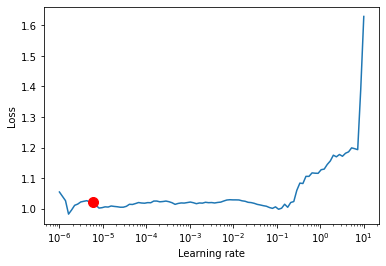

<ipython-input-11-59a85c6b8d2a>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [11]:
# Find Optimal Learning Rate:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader = train_dataloader,
    val_dataloaders = val_dataloader,
    max_lr = 10.0,
    min_lr = 1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show = True, suggest = True)
fig.show()

#tft.hparams["learning_rate"] = res.suggestion() # Set the suggested learning rate

In [12]:
# Configure Logging and Trainier:
early_stop_callback = EarlyStopping(monitor = "val_loss", min_delta = 1e-4, 
                                    patience = 10, verbose = True, mode = "min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs", name = "tft", log_graph = True)  # logging results to a tensorboard

# tensorboard --logdir=lightning_logs, run this command to load tensorboard

trainer = pl.Trainer(
    max_epochs = 10,
    gpus = 1,
    weights_summary = "top",
    gradient_clip_val = 0.03,
    #limit_train_batches = 24,  # Commet during training
    #fast_dev_run = True,
    callbacks = [lr_logger, early_stop_callback],
    logger = logger
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [13]:
# Fit Model:
trainer.fit(
    tft,
    train_dataloader = train_dataloader,
    val_dataloaders = val_dataloader,
)

C:\Users\nmert\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:530: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\nmert\anaconda3\lib\site-packages\pytorch_lightning\loggers\tensorboard.py:233: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  rank_zero_warn(

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | pre

Global seed set to 43


Epoch 0:   0%|          | 1/439 [00:00<01:40,  4.35it/s, loss=1.05, v_num=24, train_loss_step=1.050]

Finding best initial lr: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


Epoch 0: 100%|██████████| 439/439 [02:38<00:00,  2.78it/s, loss=0.482, v_num=24, train_loss_step=0.524, val_loss=0.606]

Metric val_loss improved. New best score: 0.606


Epoch 2: 100%|██████████| 439/439 [02:39<00:00,  2.77it/s, loss=0.359, v_num=24, train_loss_step=0.449, val_loss=0.491, train_loss_epoch=0.427]

Metric val_loss improved by 0.114 >= min_delta = 0.0001. New best score: 0.491


Epoch 3: 100%|██████████| 439/439 [02:38<00:00,  2.77it/s, loss=0.336, v_num=24, train_loss_step=0.405, val_loss=0.404, train_loss_epoch=0.389]

Metric val_loss improved by 0.087 >= min_delta = 0.0001. New best score: 0.404


Epoch 4: 100%|██████████| 439/439 [02:38<00:00,  2.77it/s, loss=0.276, v_num=24, train_loss_step=0.318, val_loss=0.269, train_loss_epoch=0.357]

Metric val_loss improved by 0.135 >= min_delta = 0.0001. New best score: 0.269


Epoch 5: 100%|██████████| 439/439 [02:38<00:00,  2.77it/s, loss=0.224, v_num=24, train_loss_step=0.229, val_loss=0.214, train_loss_epoch=0.310]

Metric val_loss improved by 0.056 >= min_delta = 0.0001. New best score: 0.214


Epoch 6: 100%|██████████| 439/439 [02:39<00:00,  2.76it/s, loss=0.159, v_num=24, train_loss_step=0.154, val_loss=0.111, train_loss_epoch=0.241]

Metric val_loss improved by 0.103 >= min_delta = 0.0001. New best score: 0.111


Epoch 9: 100%|██████████| 439/439 [02:39<00:00,  2.76it/s, loss=0.0996, v_num=24, train_loss_step=0.0893, val_loss=0.0747, train_loss_epoch=0.110]

Metric val_loss improved by 0.037 >= min_delta = 0.0001. New best score: 0.075


Epoch 9: 100%|██████████| 439/439 [02:39<00:00,  2.75it/s, loss=0.0996, v_num=24, train_loss_step=0.0893, val_loss=0.0747, train_loss_epoch=0.110]


# Model Evaluation:

In [14]:
# Load best model:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [15]:
x, actuals = next(iter(test_dataloader))
actuals = actuals[0].flatten()
predictions = best_tft.predict(test_dataloader)[1]

rmse = round(float(((predictions - actuals)**2).mean().sqrt()), 2)
print("RMSE: ", rmse) 

RMSE:  0.13


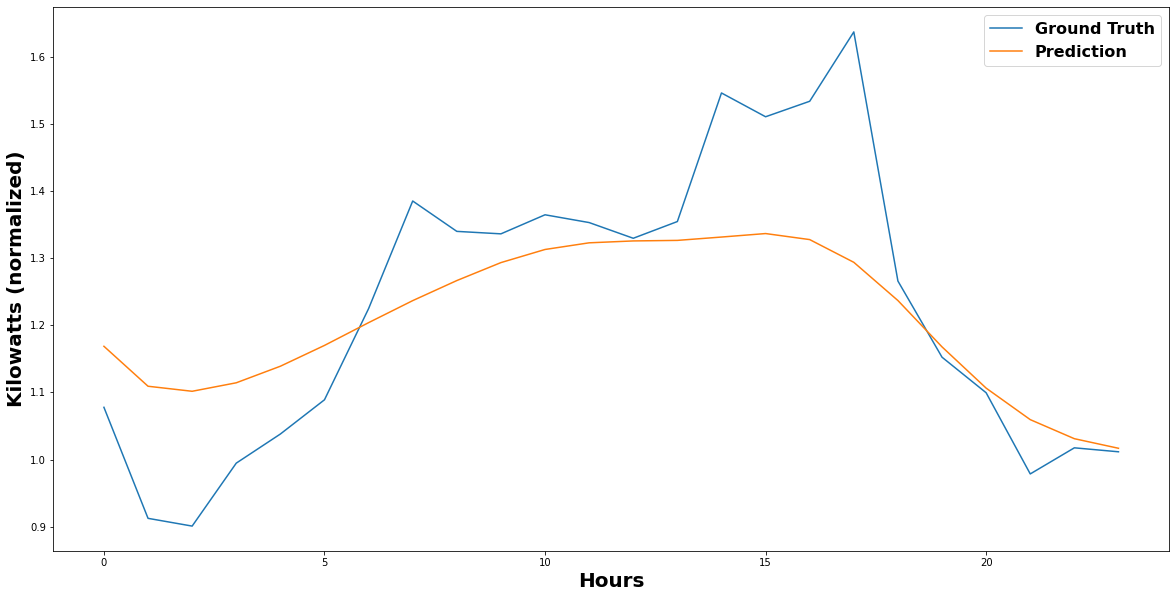

In [16]:
legend_properties = {'weight':'bold','size':'16'}
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(actuals, label = "Ground Truth")
ax.plot(predictions, label = "Prediction")
ax.set_xlabel('Hours', fontsize=20, fontweight='bold')
ax.set_ylabel('Kilowatts (normalized)', fontsize=20, fontweight='bold')
#ax.set_title("Test vs. Prediction") 
ax.legend(loc = 0, prop = legend_properties)
plt.show()

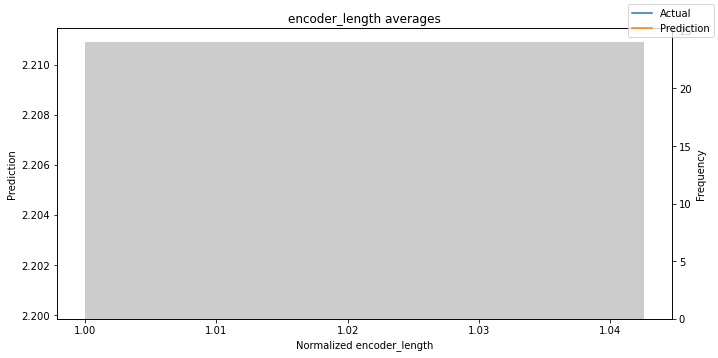

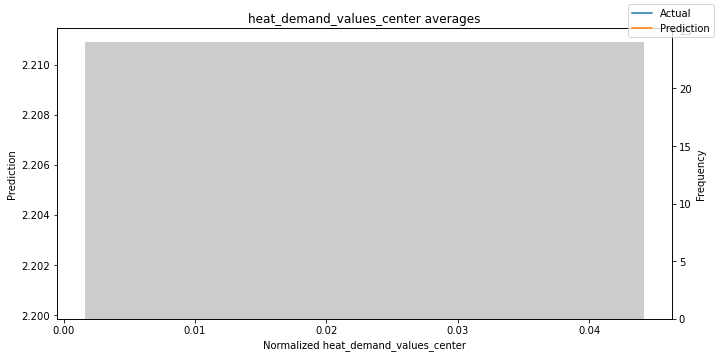

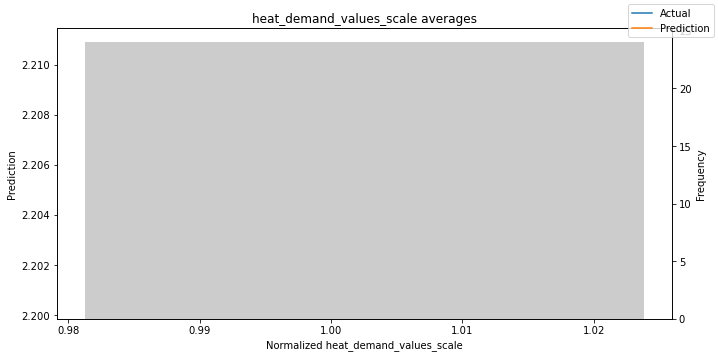

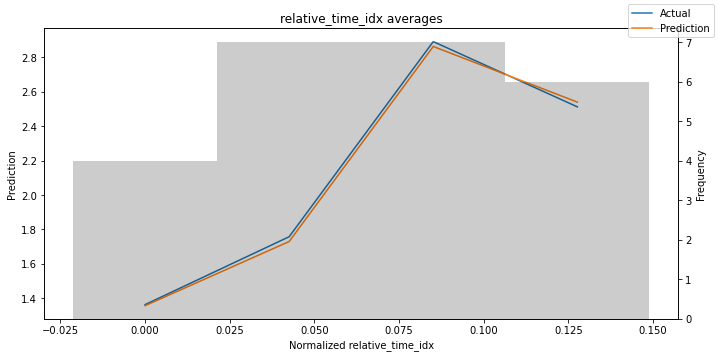

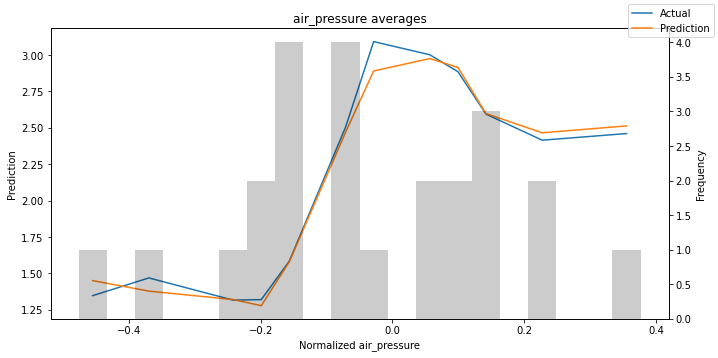

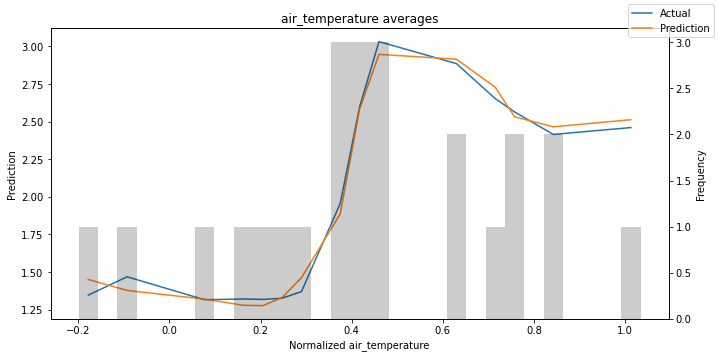

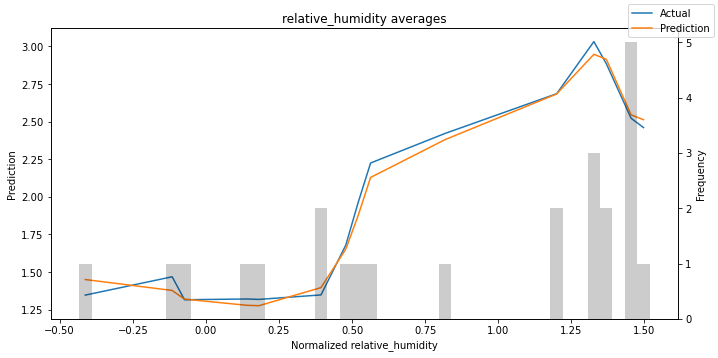

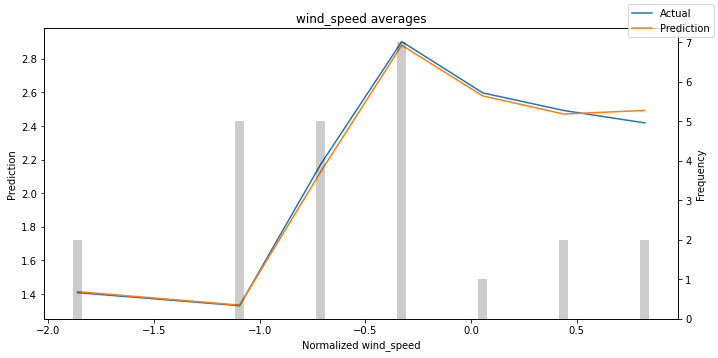

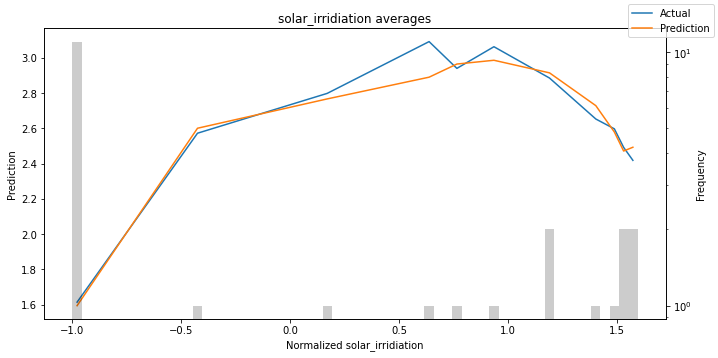

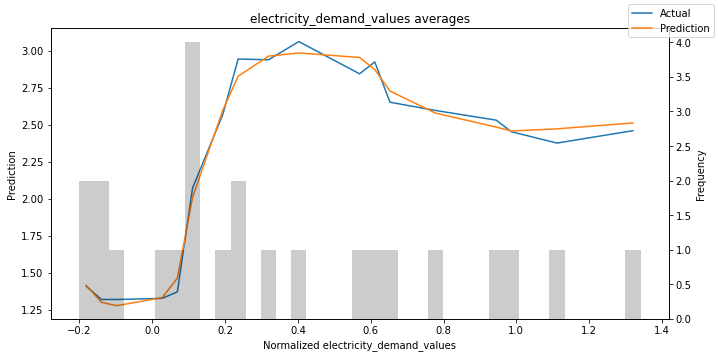

In [17]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

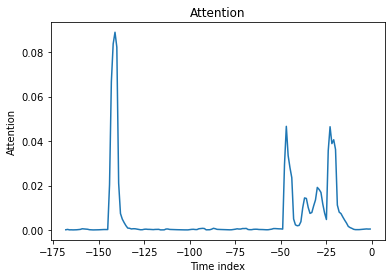

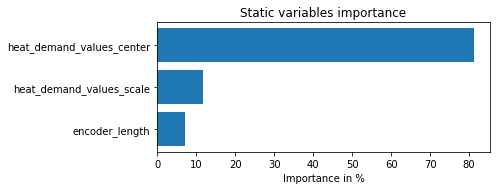

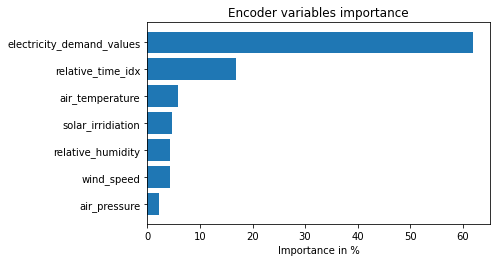

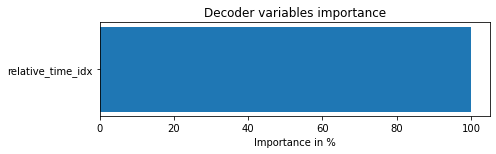

In [18]:
raw_predictions, x = best_tft.predict(val_dataloader, mode = "raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction = "sum")
best_tft.plot_interpretation(interpretation);

In [19]:
# Auto Hyperparameter tuning:
"""
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path= "tft",
    n_trials = 100,
    max_epochs = 20,
    gradient_clip_val_range = (0.01, 1.0),
    hidden_size_range = (8, 128),
    hidden_continuous_size_range = (8, 128),
    attention_head_size_range = (1, 4),
    learning_rate_range = (0.001, 0.1),
    dropout_range = (0.1, 0.5),
    trainer_kwargs = dict(limit_train_batches = 24),
    reduce_on_plateau_patience = 4,
    use_learning_rate_finder=False,
)


with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)


print(study.best_trial.params)

"""

'\nimport pickle\n\nfrom pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters\n\n# create study\nstudy = optimize_hyperparameters(\n    train_dataloader,\n    val_dataloader,\n    model_path= "tft",\n    n_trials = 100,\n    max_epochs = 20,\n    gradient_clip_val_range = (0.01, 1.0),\n    hidden_size_range = (8, 128),\n    hidden_continuous_size_range = (8, 128),\n    attention_head_size_range = (1, 4),\n    learning_rate_range = (0.001, 0.1),\n    dropout_range = (0.1, 0.5),\n    trainer_kwargs = dict(limit_train_batches = 24),\n    reduce_on_plateau_patience = 4,\n    use_learning_rate_finder=False,\n)\n\n\nwith open("test_study.pkl", "wb") as fout:\n    pickle.dump(study, fout)\n\n\nprint(study.best_trial.params)\n\n'